In [82]:
import pandas as pd
import matplotlib.pylab as plt
import os
import numpy as np
import sys

import math
from datetime import datetime
from glob import glob
from datetime import timedelta
plt.style.use('ggplot')
from mpl_toolkits.basemap import Basemap
from igrf12py.igrf12fun import runigrf12, plotigrf 
%matplotlib inline
import requests
import os
import utils
import autoreload
from scipy.optimize import fmin
from scipy import signal



In [166]:
# relative path to data dir
drifter_data_dir = 'data'
# I'm setting pretty conservative start/stop times based on plots of the data
base_drifter_dict = {
            'bashful':{'type':'HMR', 'id':68740, 'launch':'2012-09-05 00:00:00', 'end':'2013-02-15 00:00:00'}, 
            'grumpy': {'type':'HMR', 'id':11070, 'launch':'2012-08-23 00:00:00', 'end':'2013-01-15 00:00:00'}, 
            'dopey':  {'type':'APS', 'id':68760, 'bias':[-40., -125., -26.],
                       'launch':'2012-09-15 00:00:00', 'end':'2013-01-01 00:00:00'}, 
             # sleepy looks like the z measurement is dominating the signal 
            'sleepy': {'type':'APS', 'id':19370, 
                       'launch':'2012-09-01 00:00:00', 'end':'2013-06-01 00:00:00'}, 
            'sneezy': {'type':'APS', 'id':66760, 
                       'launch':'2012-08-26 00:00:00', 'end':'2012-10-12 00:00:00'}, 
            }



In [84]:
# load the txt files that we've created
reload(utils)
drifter_dict = utils.parse_txt_files(drifter_data_dir, base_drifter_dict)

Loading sneezy meas, cal, and list data files
Loading sleepy meas, cal, and list data files
Loading grumpy meas, cal, and list data files
Loading bashful meas, cal, and list data files
Loading dopey meas, cal, and list data files


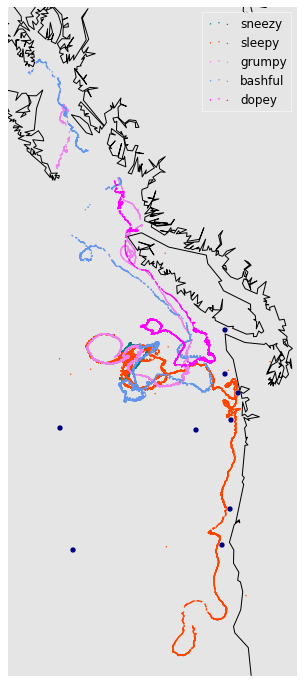

In [85]:
# build a map of all of the data files
# reference buoys are denoted by circles
plt.figure(figsize=(20,12))
m = Basemap(projection='merc', ellps='WGS84',
           llcrnrlat=39, 
           urcrnrlat=56, 
           llcrnrlon=-133,
           urcrnrlon=-122,
           resolution='l')

cc = ['teal', 'orangered', 'violet', 'cornflowerblue', 'magenta']
for nn, drifter in enumerate(drifter_dict.keys()):
    md = drifter_dict[drifter]['meas']
    x, y = m(np.array(md['lon']), np.array(md['lat']))
    m.scatter(x, y, c=cc[nn], edgecolor="None", s=2, label=drifter)
  
for bid in utils.buoy_list.keys():    
    latb, lonb = utils.buoy_list[bid]
    xb, yb = m(np.array(lonb), np.array(latb))
    m.scatter(xb, yb, s=35, c='navy', marker='o')

m.drawcoastlines()
plt.legend()
plt.show()

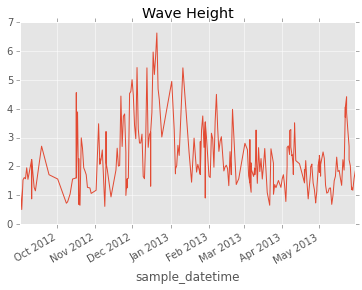

In [168]:
# load drifter calibration routine
dn = 'sleepy'
sn = drifter_dict[dn]['cal']
sn = sn.drop_duplicates(take_last=True)
# for this dataset, only look at data that we have found WVHT data for
wv = sn.loc[sn['WVHT'] > 0]
# 99 is used as an invalid marker in the buoy dataset
wv = wv.loc[wv['WVHT'] < 99]
plt.title("Wave Height")
wv['WVHT'].plot()

orange - low waves (avg 0.6 m) had variance in f measured of 187936601
teal - high waves (avg 5.0 m) had variance in f measured of 381037289


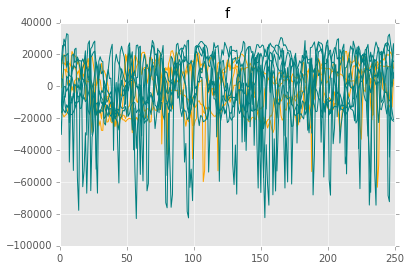

In [170]:
# the data below suggests that we see much less variance in the measurements on days in which 
# the wave height was low. 
# set the variable to compare here
column = 'f'
# set maximum wave height to consider low height
low_height = 0.7
# set minimum height to consider
high_height = 4

plt.figure()
plt.title(column)

# select only wave height under low_height
low = wv.loc[wv['WVHT'] < low_height]
# the dataframe is indexed by sample time, but we want a list of all samples in this cal routine, 
# so isolate based on cal_start time
sample_start_times_low = low['cal_start_datetime'].unique()
low_waves = []
# keep track of sum of variances
vsl = 0
wave_l = 0
for ss in sample_start_times_low:
    # look at the sample_times from this calibration start time
    ll = low.loc[low['cal_start_datetime'] == ss]
    l = list(ll[column])
    # only use lists that have the full calibration routines
    if len(l) == 250:
        vl = round(np.var(l),1)
        bb = plt.plot(l-np.mean(l), 'orange')
        vsl += vl
        wave_l += np.mean(ll['WVHT'])
        low_waves.append(l)
if len(sample_start_times_low):        
    vsl = int((vsl/len(low_waves)))
    wave_l = wave_l/len(low_waves)
    ###################################################
    print('orange - low waves (avg %s m) had variance in %s measured of %s' %(round(wave_l,1), column, vsl))
else:
    print("no samples found where wave height was below %m" %low_hight)

high = wv.loc[wv['WVHT'] > high_height]
high = high.loc[high.index.unique()]
sample_start_times_high = high['cal_start_datetime'].unique()
high_waves = []
vsh = 0
wave_h = 0

for ss in sample_start_times_high:
    # look at the sample_times from this calibration start time
    hl = high.loc[high['cal_start_datetime'] == ss]
    h = list(hl[column])
    # only use lists that have the full calibration routines
    if len(h) == 250:
        vh = round(np.var(h),1)
        vsh += vh
        rr = plt.plot(h-np.mean(h), 'teal')
        high_waves.append(h)
        wave_h += np.mean(hl['WVHT'])
if len(sample_start_times_high):        
    vsh = int((vsh/len(high_waves)))
    wave_h = wave_h/len(high_waves)
    ###################################################
    print('teal - high waves (avg %s m) had variance in %s measured of %s' %(round(wave_h,1), column, vsh))
else:
    print("no samples found where wave height was above %s m" %high_height)

wave height mean 0.5
calc f:129.75 model f:53.34 error:76.41


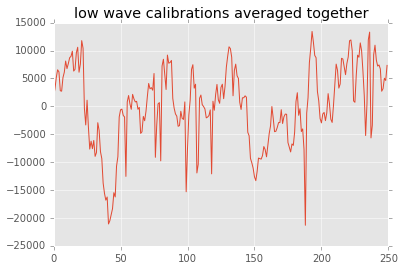

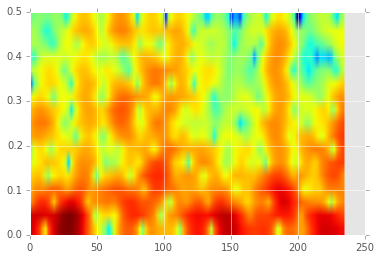

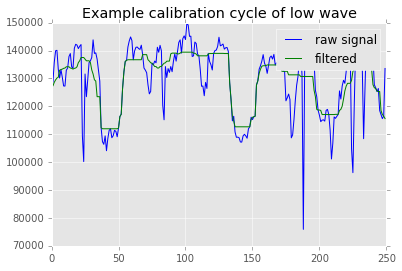

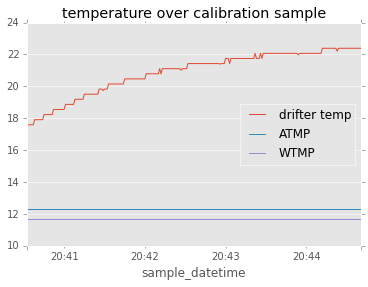

In [171]:
# look at the specgram to determine if there is any structured noise
NFFT = 32
overlap = 30
Fs=1
if len(low_waves):
    # look at time series of each calibration that occurred during a low wave period
    xl = np.mean(np.vstack(low_waves), axis=0)
    xnl = xl-np.mean(xl)
    plt.figure()
    plt.title("low wave calibrations averaged together")
    plt.plot(xnl)
    plt.figure()
    Pxxl, freqsl, binsl, iml = plt.specgram(xnl, Fs=Fs, NFFT=NFFT, noverlap=overlap)
    
    # filter low waves
    # data looks just as bad throughout the cal cycle - 
    # electronics temperature is much warmer than air or water temp and increases over the calibration period
    # electronic temp increases about 5' each cal cycle
    plt.figure()
    lw = np.array(low_waves[0])
    plt.title('Example calibration cycle of low wave')
    # filter noise from low waves
    plt.plot(lw, 'b', label='raw signal')
    my = signal.medfilt(lw, kernel_size=23)
    plt.plot(my, 'g', label='filtered')
    plt.legend()
    guess = my.mean()/1000
    ln = sample_start_times_low[0]
    ll = low.loc[low['cal_start_datetime'] == ln]
    model = ll['igrff'].mean()/1000
    print('wave height mean %s' %(round(ll['WVHT'].mean(),2)))
    print('calc f:%s model f:%s error:%s' %(round(guess, 2), round(model,2), round(abs(guess-model), 2)))
    la = ll.resample('D')
    la.head()
    plt.show()

    ll.rename(columns={'temp':'drifter temp'}, inplace=True)
    ll[['drifter temp', 'ATMP', 'WTMP']].plot(title='temperature over calibration sample')
    la.head()

wave height mean 4.56
calc f:121.06 model f:53.34 error:67.73


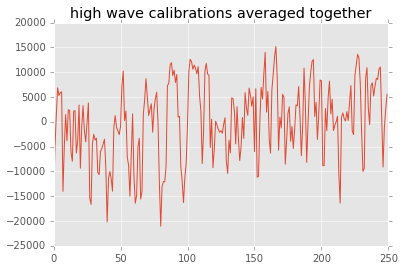

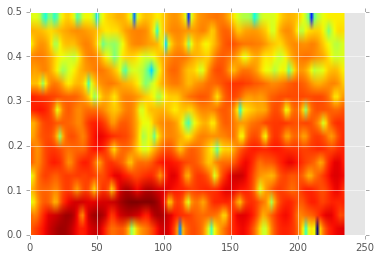

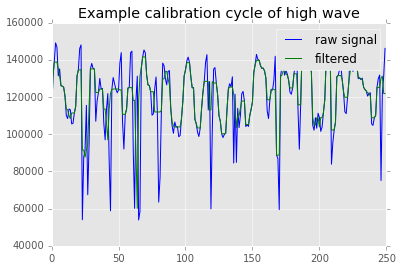

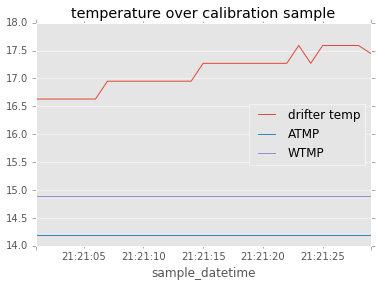

In [175]:
# there is a ton more high frequency content in the data taken during 
# periods of high waves
if len(high_waves):
    xh = np.mean(np.vstack(high_waves), axis=0)
    xnh = xh-np.mean(xh)
    plt.figure()
    plt.title("high wave calibrations averaged together")
    plt.plot(xnh)
    plt.figure()
    Pxxh, freqsh, binsh, imh = plt.specgram(xnh, Fs=1, NFFT=NFFT, noverlap=overlap)
    
    # filter noise from high waves
    xx = 0
    plt.figure()
    plt.title('Example calibration cycle of high wave')
    hw = np.array(high_waves[xx])
    plt.plot(hw, 'b', label='raw signal')
    my = signal.medfilt(hw, kernel_size=5)
    plt.plot(my, 'g', label='filtered')
    plt.legend()
    guess = my.mean()/1000
    hn = sample_start_times_high[xx]
    hh = high.loc[high['cal_start_datetime'] == hn]
    model = hh['igrff'].mean()/1000
    print('wave height mean %s' %(round(hh['WVHT'].mean(),2)))
    print('calc f:%s model f:%s error:%s' %(round(guess, 2), round(model,2), round(abs(guess-model), 2)))
    la = hh.resample('D')
    la.head()
    plt.show()
    hh.rename(columns={'temp':'drifter temp'}, inplace=True)
    hh[['drifter temp', 'ATMP', 'WTMP']].plot(title='temperature over calibration sample')


It is obvious that the data collected on high (>4m) wave days has much more high frequency content 
than the data collected during calm days (<1m) . Let's see if we can pull some of the high frequency 
content out. I looked at a low pass filter in and didn't have much luck. Below, I revert to a simple 
median filter for smoothing outliers and find pretty good results.

In [176]:
def sensor_minimize(vec, xf, yf, zf, ref):
#def sensor_minimize(vec, x, ref):
    """ 
    Minimize the total field variation of the Drifter magnetometer by varying offsets and calibration factors.  
    """
    #tf1=np.sqrt(((xf-xdc)*xcf)**2+((yf-ydc)*ycf)**2+((zf-zdc)*zcf)**2)
    #tfmn=np.sum(ref-np.mean(tf1));
    tf1=np.sqrt((xf+vec[0])**2+(yf+vec[1])**2+(zf+vec[2])**2)

    # the difference between the reference f and biased f should be close to zero
    tfmn = np.mean(np.abs(ref-tf1))
    return tfmn

In [177]:
def find_bias(bias, x, y, z, ref):
    bias = fmin(sensor_minimize, x0=bias, args=(x, y, z, ref))
    ft = utils.to_total_field(x+bias[0], y+bias[1], z+bias[2])
    return bias, ft

def filter_and_bias(df, kernel_size, bias):
    df.loc[:,'x nT'] = df['x']
    df.loc[:,'y nT'] = df['y']
    df.loc[:,'z nT'] = df['z']
    df.loc[:,'igrff nT'] = df['igrff']
    df.loc[:,'igrfx nT'] = df['igrfx']
    df.loc[:,'igrfy nT'] = df['igrfy']
    df.loc[:,'igrfz nT'] = df['igrfz']
    
    x = signal.medfilt(df['x nT'], kernel_size=kernel_size)
    y = signal.medfilt(df['y nT'], kernel_size=kernel_size)
    z = signal.medfilt(df['z nT'], kernel_size=kernel_size)

    
    bias, ft = find_bias(bias, x, y, z, df['igrff nT'])
    print('found bias of', bias)
    

    df.loc[:,'clean f nT'] = ft
    error = abs(df['igrff nT']-df['clean f nT'])
    df.loc[:,'error'] = error
    
    
    df.loc[:,'clean x nT'] = x + bias[0]
    df.loc[:,'clean y nT'] = y + bias[1]
    df.loc[:,'clean z nT'] = z + bias[2]
    
    return df


In [178]:
def plot_relationships(df):
    """expects data frame that has already been run through add bias"""
    cols = ['bat', 'temp', 'WVHT', 'WTMP', 'ATMP', 'WDIR', 'WSPD', 'GST',
            'DPD', 'APD', 'MWD', 'PRES', 'lat', 'lon']

    df.loc[:,cols+['error']] = df[cols+['error']].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
    for col in cols:
        # some buoy data isn't available
        ll = df.loc[df[col] != 99]
        ll = ll.loc[ll[col] != 999]
        ll = ll.loc[ll[col] != 9999]
        print(col, ll.shape)
        if ll.shape[0]:
            plt.figure()
            ll[['error', col]].plot(figsize=(18,6))
            plt.show()


Optimization terminated successfully.
         Current function value: 1924.247506
         Iterations: 229
         Function evaluations: 410
('found bias of', array([  26879.17063246,  117699.59229239,   26436.60065591]))
('bat', (65360, 47))


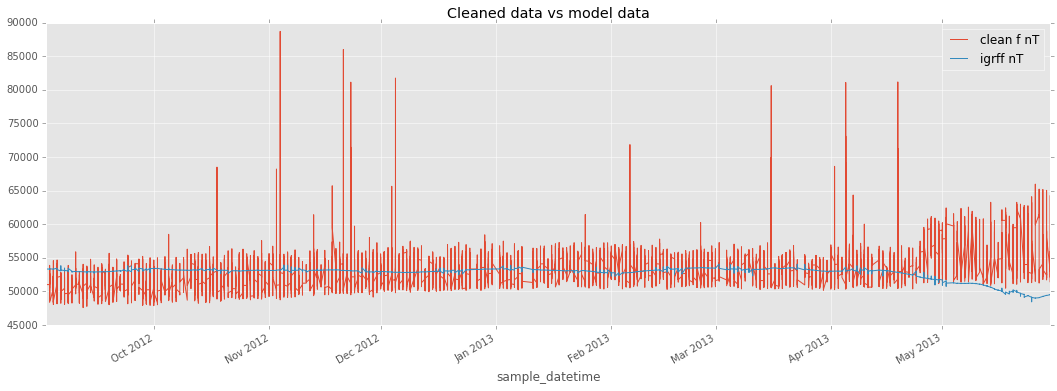

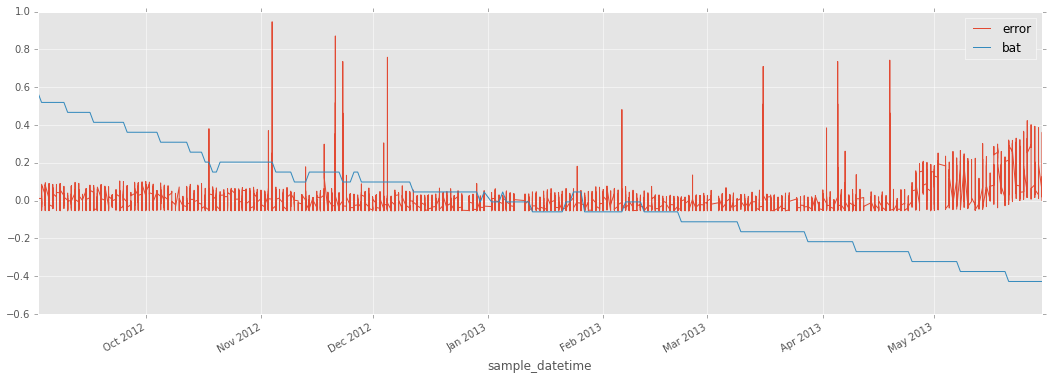

('temp', (65360, 47))


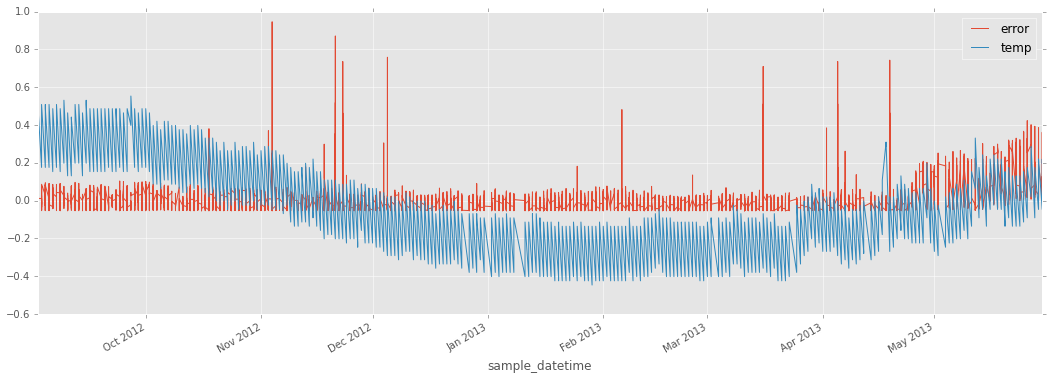

('WVHT', (65360, 47))


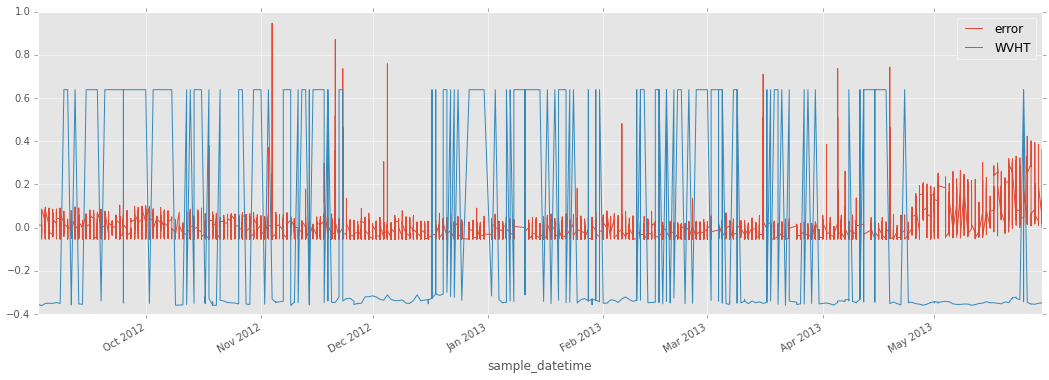

('WTMP', (65360, 47))


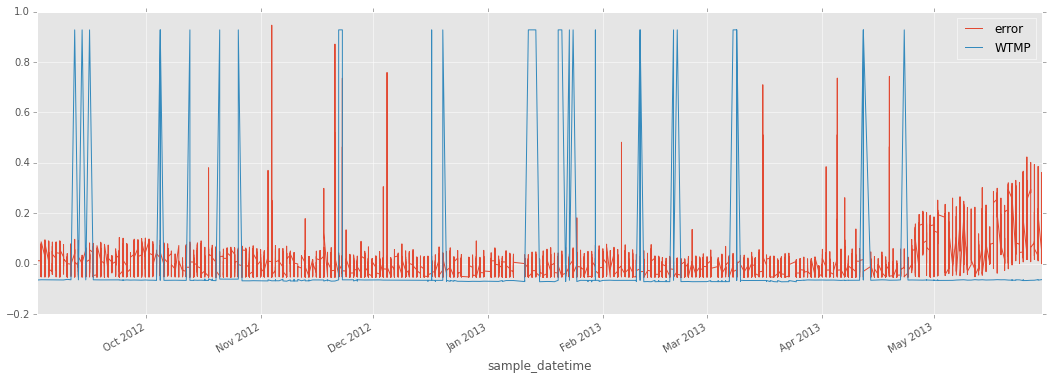

('ATMP', (65360, 47))


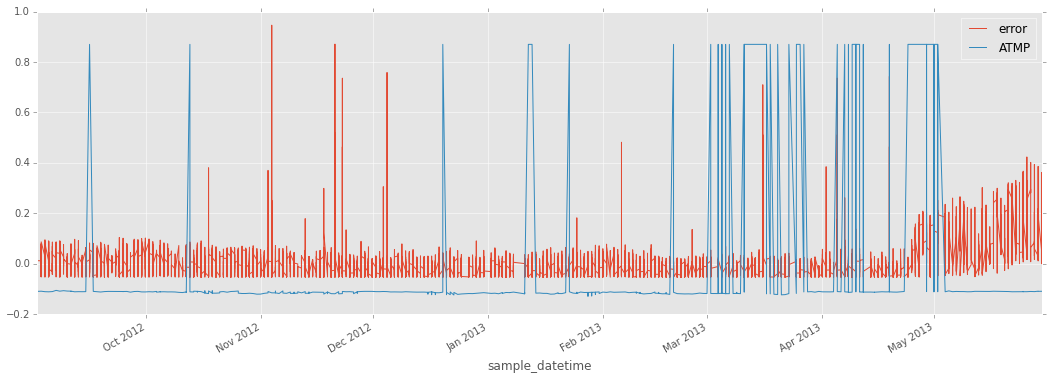

('WDIR', (65360, 47))


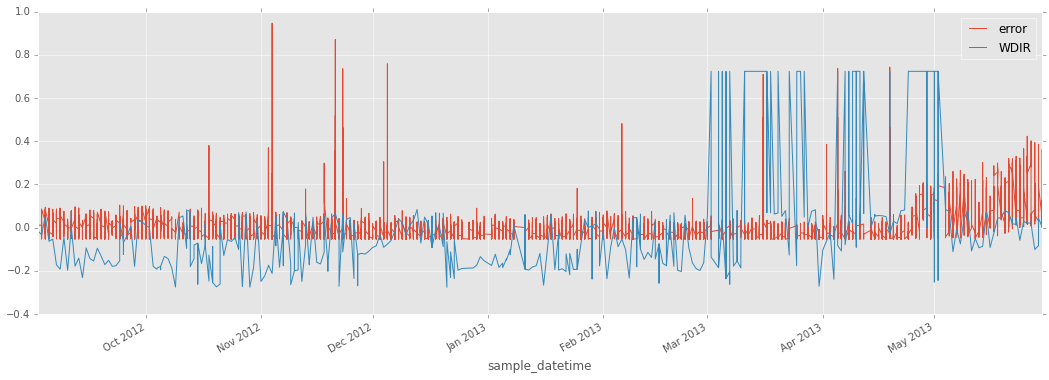

('WSPD', (65360, 47))


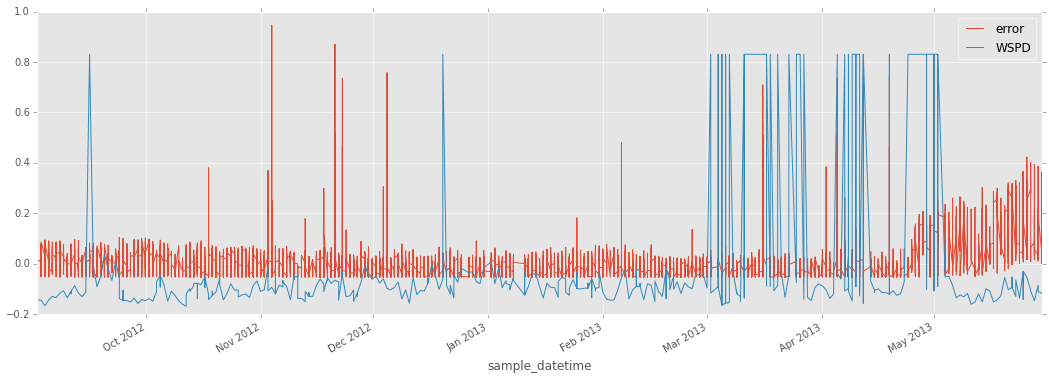

('GST', (65360, 47))


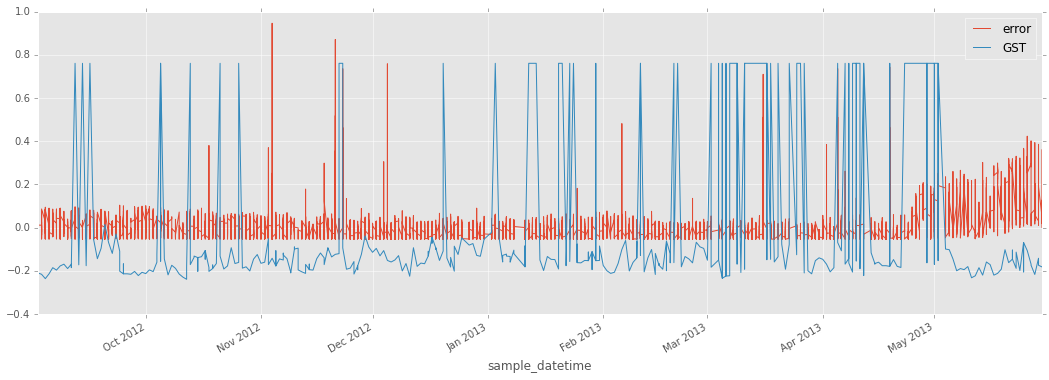

('DPD', (65360, 47))


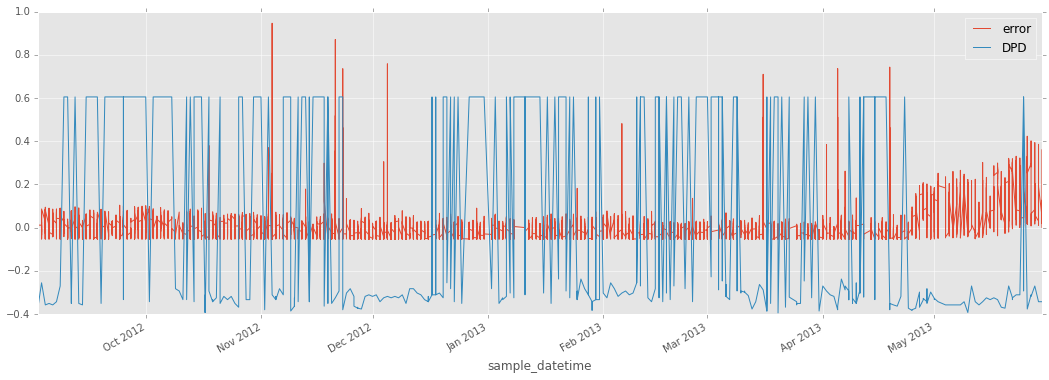

('APD', (65360, 47))


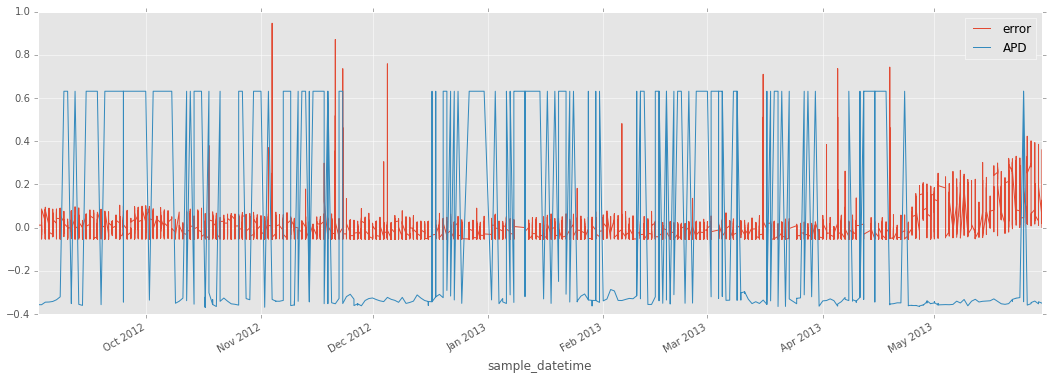

('MWD', (65360, 47))


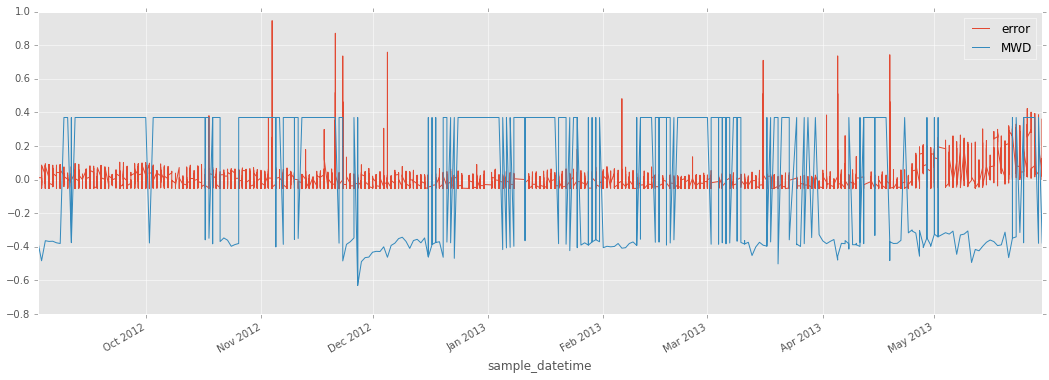

('PRES', (65360, 47))


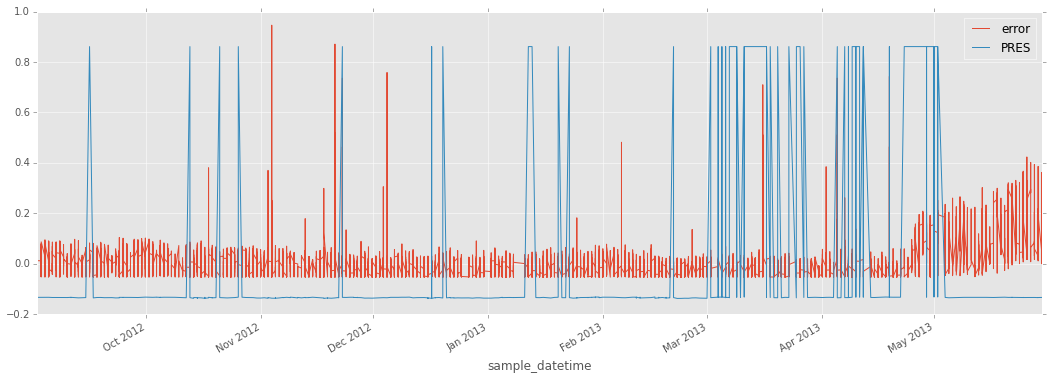

('lat', (65360, 47))


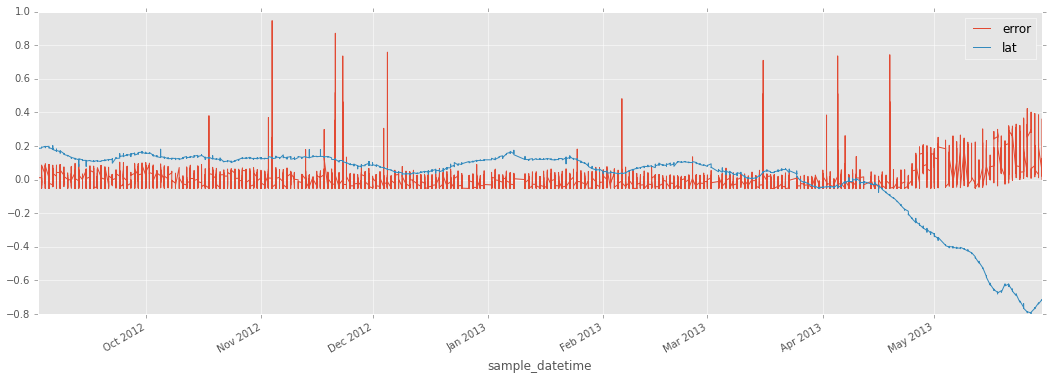

('lon', (65360, 47))


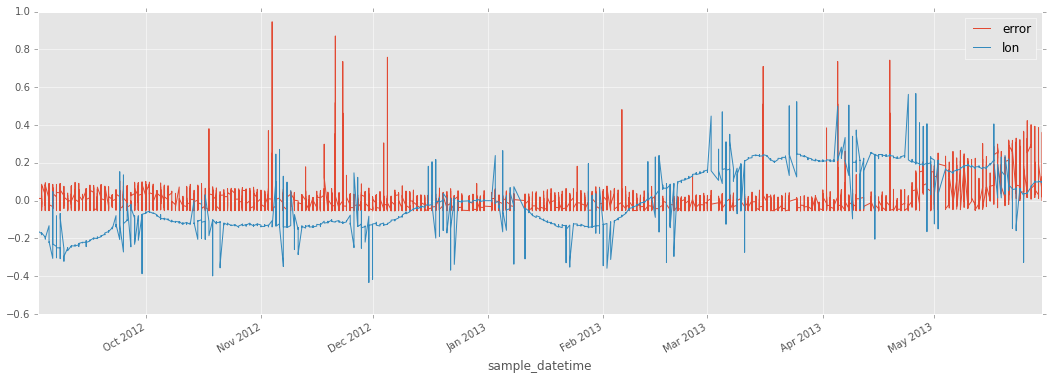

In [179]:
# apply all of the things we've learned
dn = 'sleepy'
# when the electronics tmp gets above about 13, the signal tends to get noiser
# temperature rises during the 4 minute calibration routine pretty steadily
max_tmp = 25
on = drifter_dict[dn]['cal']
on = on.drop_duplicates(take_last=True)
on = utils.get_model_df(on)
bias = [-40000., -125000., -26000.]
# remove electronic tmps above max_tmp
sn = on.loc[on['temp'] < max_tmp]

# kernel size for x,y,z median filter
median_kernel = 11
#sn, bias = 
sn = filter_and_bias(sn, median_kernel, bias)
sn[['clean f nT', 'igrff nT']].plot(title='Cleaned data vs model data', figsize=(18,6))
plot_relationships(sn)
#TODO
# lay lots of cal error on top of each other
# lay lots of tmp increases


In [ ]:
# apply all of the things we've learned
dn = 'sneezy'
# when the electronics tmp gets above about 13, the signal tends to get noiser
# temperature rises during the 4 minute calibration routine pretty steadily
max_tmp = 25
on = drifter_dict[dn]['cal']

on = on.drop_duplicates(take_last=True)
on = utils.get_model_df(on)
bias = [-40000., -125000., -26000.]
# remove electronic tmps above max_tmp
sn = on.loc[on['temp'] < max_tmp]

# kernel size for x,y,z median filter
median_kernel = 11
#sn, bias = 
sn = filter_and_bias(sn, median_kernel, bias)
sn[['clean f nT', 'igrff nT']].plot(title='Cleaned data vs model data', figsize=(18,6))
# notice that the signal gets noiser at the end of the mission
plot_relationships(sn)

Optimization terminated successfully.
         Current function value: 1213.771643
         Iterations: 249
         Function evaluations: 445
('found bias of', array([  35487.87447364,  105903.13493059,  -70847.50306838]))
('bat', (21850, 47))


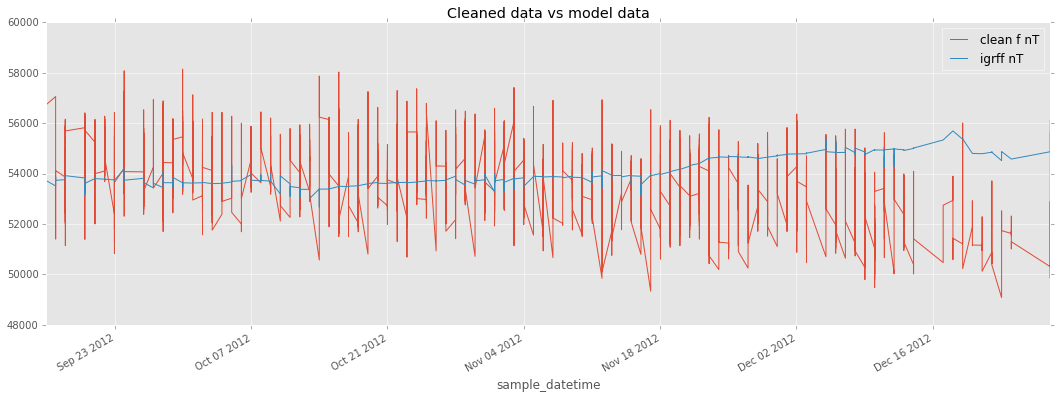

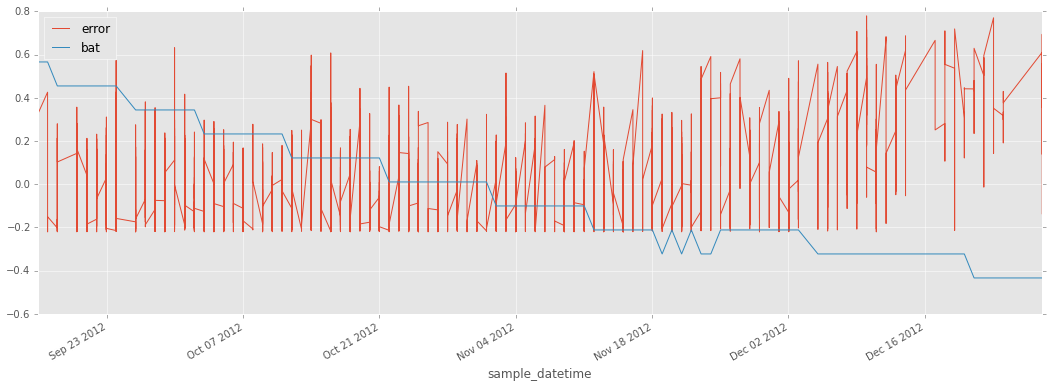

('temp', (21850, 47))


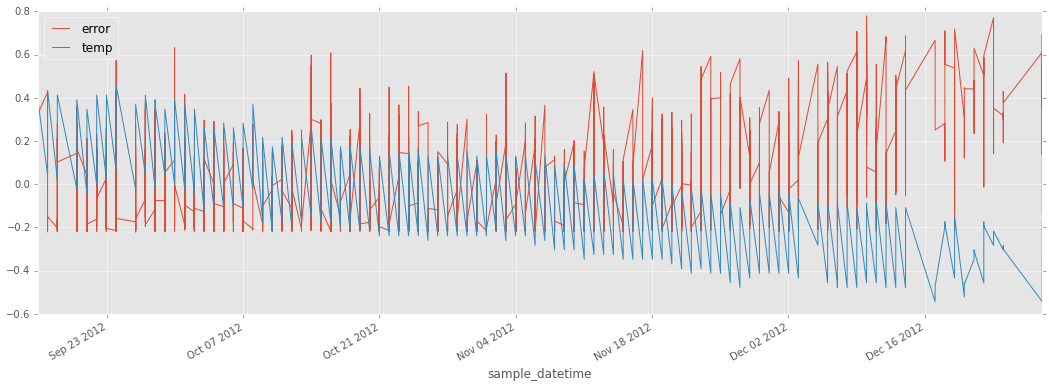

('WVHT', (21850, 47))


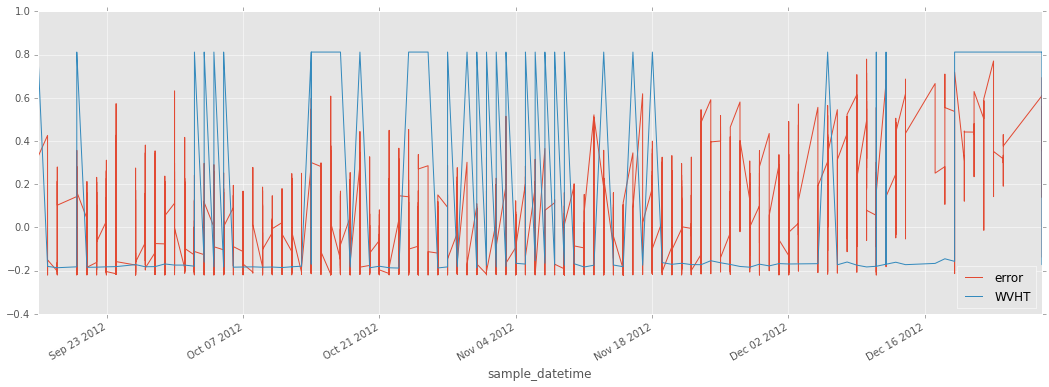

('WTMP', (21850, 47))


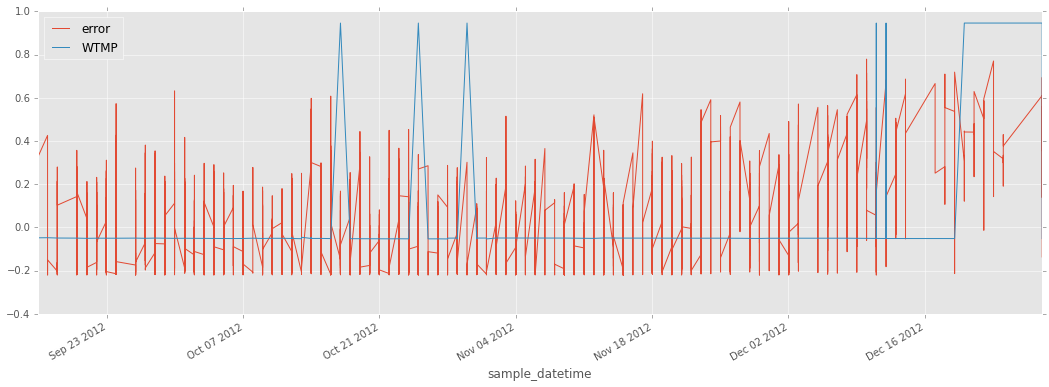

('ATMP', (21850, 47))


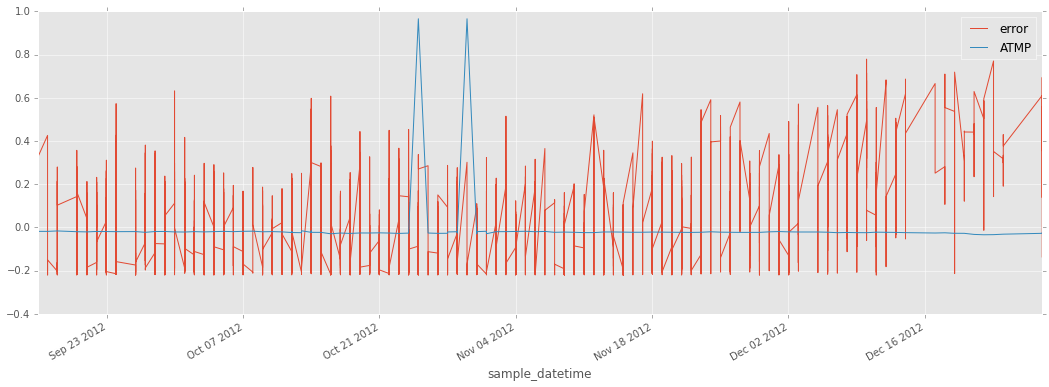

('WDIR', (21850, 47))


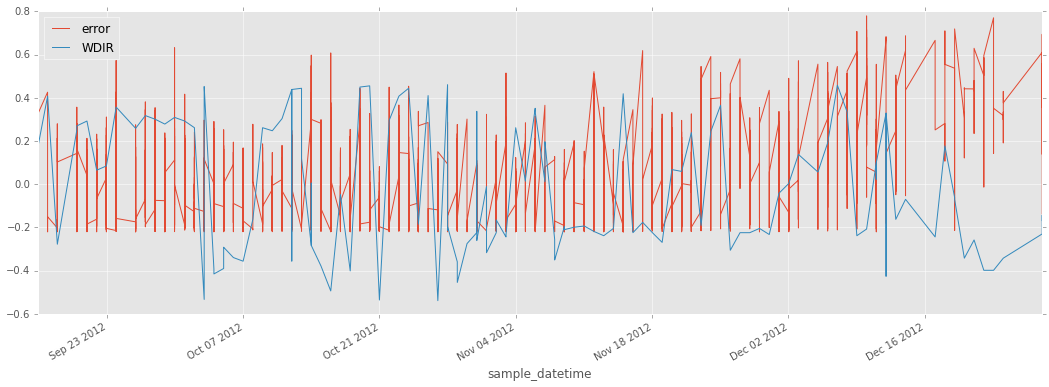

('WSPD', (21850, 47))


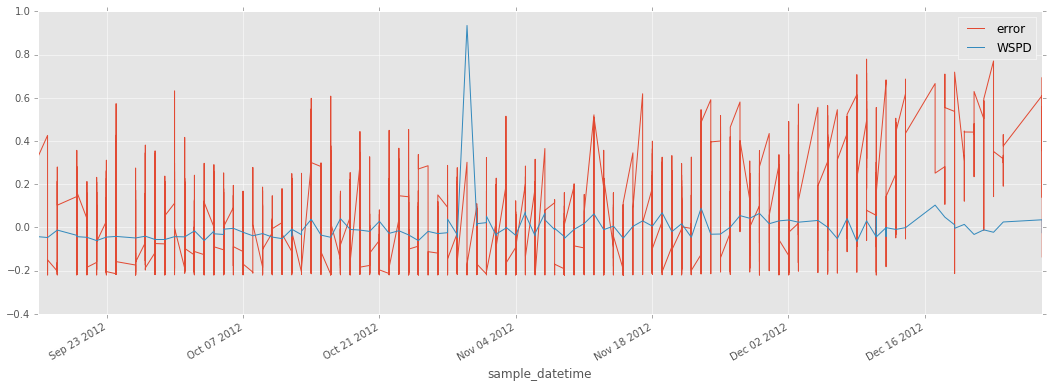

('GST', (21850, 47))


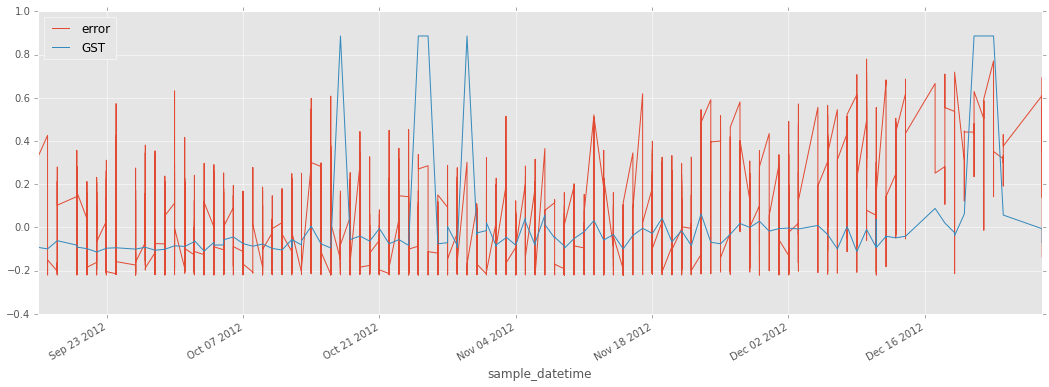

('DPD', (21850, 47))


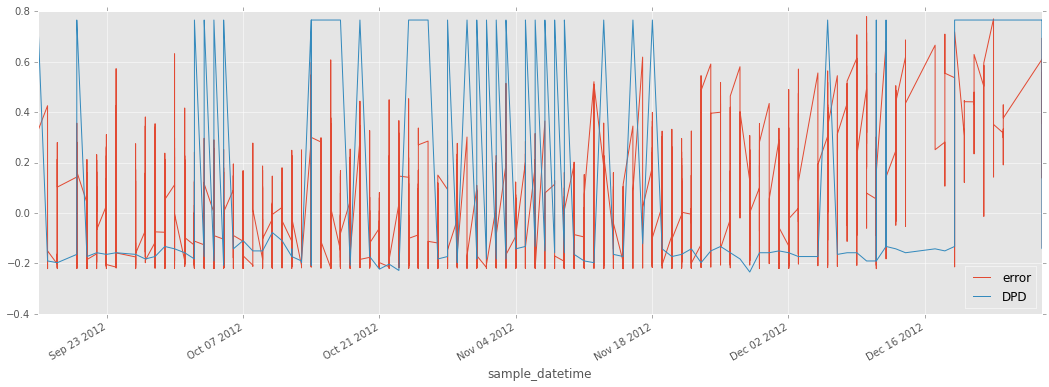

('APD', (21850, 47))


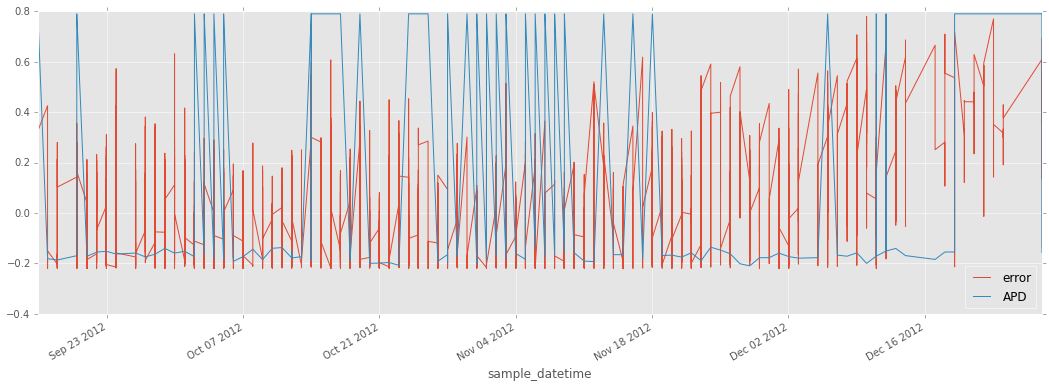

('MWD', (21850, 47))


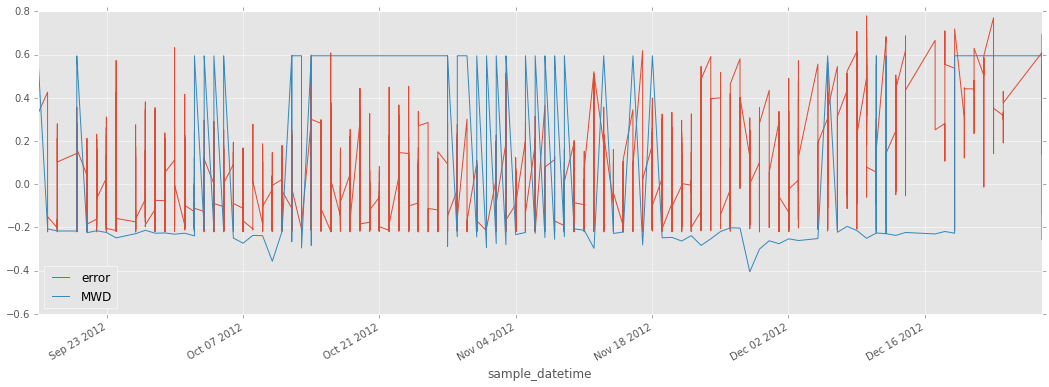

('PRES', (21850, 47))


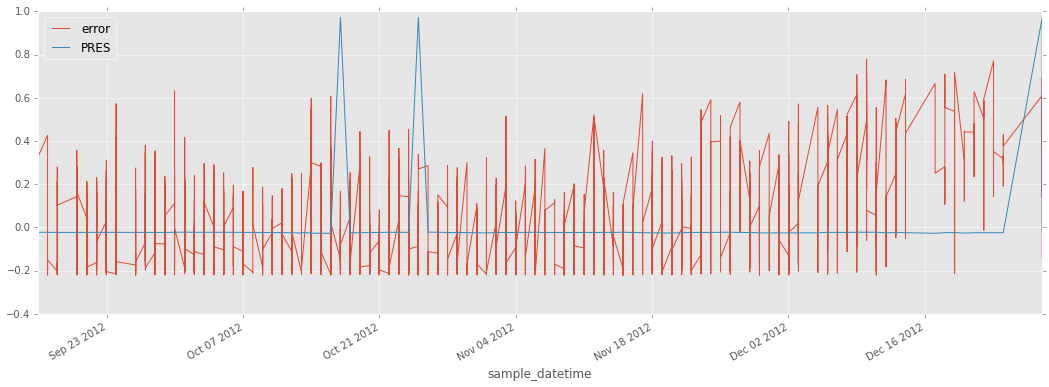

('lat', (21850, 47))


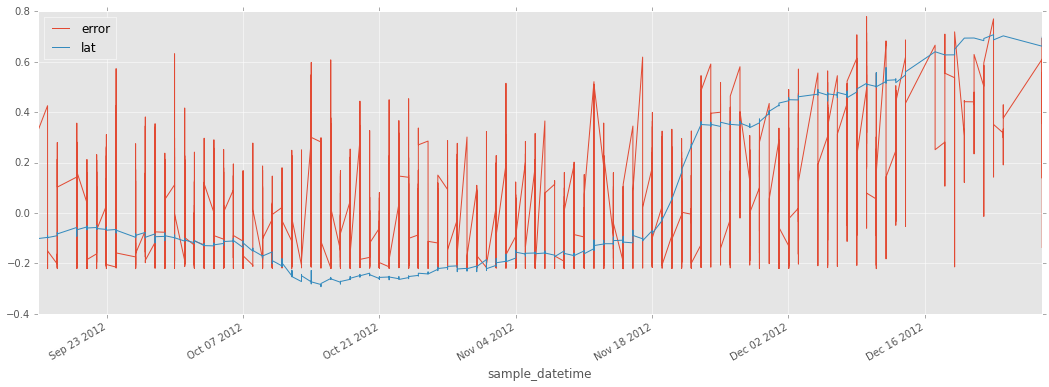

('lon', (21850, 47))


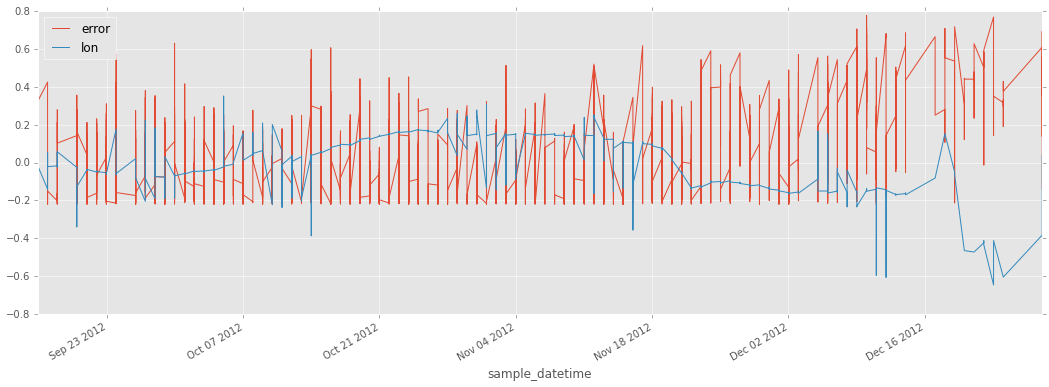

In [ ]:
# apply all of the things we've learned
dn = 'dopey'
# when the electronics tmp gets above about 13, the signal tends to get noiser
# temperature rises during the 4 minute calibration routine pretty steadily
max_tmp = 25
on = drifter_dict[dn]['cal']

on = on.drop_duplicates(take_last=True)
on = utils.get_model_df(on)
bias = [-40000., -125000., -26000.]
# remove electronic tmps above max_tmp
sn = on.loc[on['temp'] < max_tmp]

# kernel size for x,y,z median filter
median_kernel = 11
#sn, bias = 
sn = filter_and_bias(sn, median_kernel, bias)
sn[['clean f nT', 'igrff nT']].plot(title='Cleaned data vs model data', figsize=(18,6))
# notice that the signal gets noiser at the end of the mission
plot_relationships(sn)


In [ ]:
# apply all of the things we've learned
# I think that I've already fixed the HMR sensors in the raw file, but I should double check
dn = 'grumpy'
# when the electronics tmp gets above about 13, the signal tends to get noiser
# temperature rises during the 4 minute calibration routine pretty steadily
max_tmp = 25
on = drifter_dict[dn]['cal']

on = on.drop_duplicates(take_last=True)
on = utils.get_model_df(on)
bias = [-40000., -125000., -26000.]
# remove electronic tmps above max_tmp
sn = on.loc[on['temp'] < max_tmp]

# kernel size for x,y,z median filter
median_kernel = 11
#sn, bias = 
sn = filter_and_bias(sn, median_kernel, bias)
sn[['clean f nT', 'igrff nT']].plot(title='Cleaned data vs model data', figsize=(18,6))
# notice that the signal gets noiser at the end of the mission
plot_relationships(sn)

In [ ]:
# apply all of the things we've learned
dn = 'bashful'
# when the electronics tmp gets above about 13, the signal tends to get noiser
# temperature rises during the 4 minute calibration routine pretty steadily
max_tmp = 25
on = drifter_dict[dn]['cal']

on = on.drop_duplicates(take_last=True)
on = utils.get_model_df(on)
bias = [-40000., -125000., -26000.]
# remove electronic tmps above max_tmp
sn = on.loc[on['temp'] < max_tmp]

# kernel size for x,y,z median filter
median_kernel = 11
#sn, bias = 
sn = filter_and_bias(sn, median_kernel, bias)
sn[['clean f nT', 'igrff nT']].plot(title='Cleaned data vs model data', figsize=(18,6))
# notice that the signal gets noiser at the end of the mission
plot_relationships(sn)

In [ ]:
# things that might contribute to noise
# battery voltage dropping 
# increased electronic temperature